**Project**: **Market** **Trend** **Analysis** **using** **LSTM**

**1. Problem Definition & Objective**

**a**. **Selected** **Project** **Track**
Market Trend Analysis (Financial Forecasting)

**b**. **Problem Statement**

The financial market is characterized by high volatility and non-linear patterns, making it difficult for investors to anticipate price movements. Traditional statistical methods often fail to capture long-term dependencies in time-series data. This project aims to predict the future closing price of a specific stock (e.g., Apple Inc. - AAPL) based on historical data, thereby identifying potential upward or downward market trends.

**c. Real-world Relevance**

Accurate trend analysis assists retail and institutional investors in risk management and decision-making. By automating the detection of price trends using AI, we can reduce emotional bias in trading and provide data-driven insights for portfolio optimization.

**2. Data Understanding & Preparation**

**a. Dataset Source**

We use publicly available market data via the Yahoo Finance API (yfinance). This allows us to access real-time and historical daily stock prices (Open, High, Low, Close, Volume).

**b. Data Loading and Exploration**


We will fetch the last 10 years of historical data for Apple Inc. (AAPL) to ensure sufficient training samples.

In [ ]:
# 2.1 Install necessary library
!pip install yfinance numpy pandas scikit-learn tensorflow matplotlib

# 2.2 Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 2.3 Load Data
STOCK_SYMBOL = 'AAPL'  # Apple Inc.
START_DATE = '2015-01-01'
END_DATE = '2024-01-01'

print(f"Downloading data for {STOCK_SYMBOL}...")
df = yf.download(STOCK_SYMBOL, start=START_DATE, end=END_DATE)

# Display first few rows
print(f"Dataset Shape: {df.shape}")
df.head()

/tmp/ipython-input-27024871.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(STOCK_SYMBOL, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Dataset Shape: (2264, 5)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237547,24.705316,23.798597,24.694231,212818400
2015-01-05,23.554741,24.086801,23.368521,24.006992,257142000
2015-01-06,23.556961,23.816340,23.195602,23.619034,263188400
2015-01-07,23.887278,23.987038,23.654501,23.765347,160423600
2015-01-08,24.805082,24.862723,24.097885,24.215383,237458000


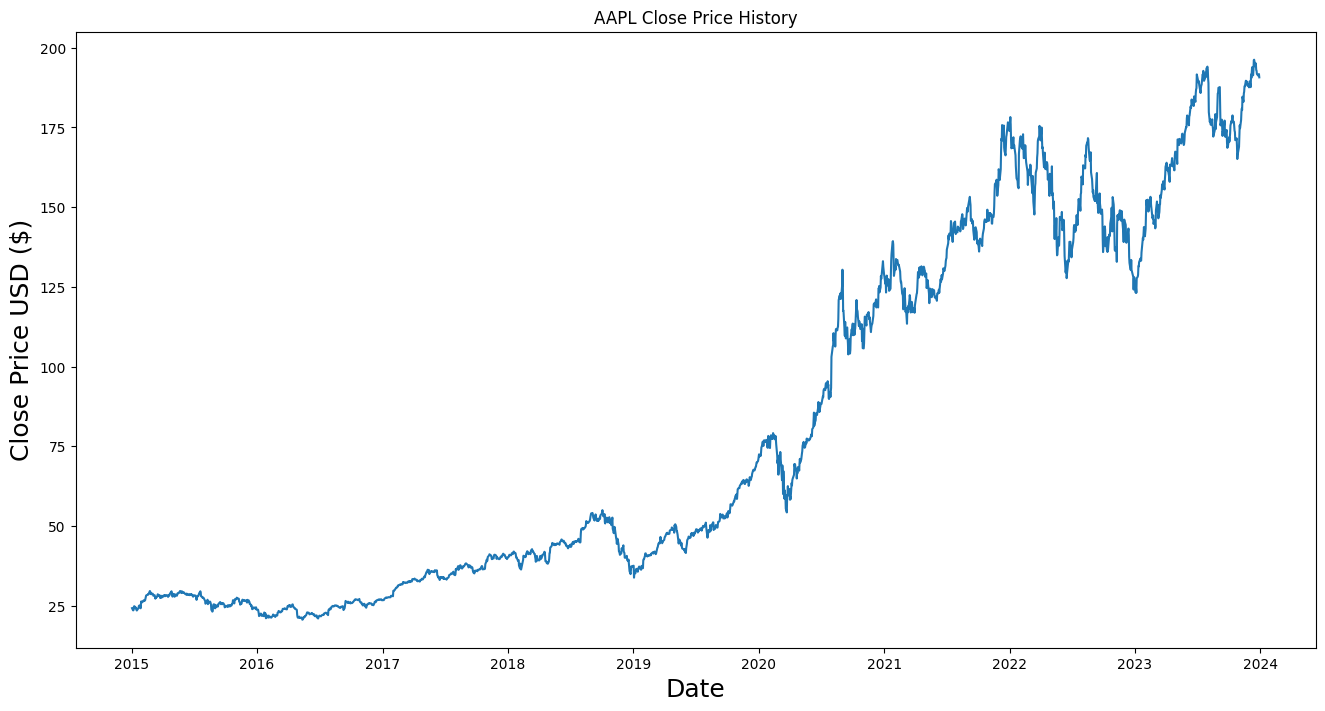

In [ ]:
# 2.4 Data Exploration (Visualizing the Trend)
plt.figure(figsize=(16,8))
plt.title(f'{STOCK_SYMBOL} Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

**c. Cleaning & Preprocessing**

Feature Selection: We focus on the 'Close' price as our target variable.
Normalization: specific Deep Learning models like LSTM converge faster with data scaled between 0 and 1. We use MinMaxScaler.
Sequence Generation: We transform the time-series data into a supervised learning format. We use a 60-day window, meaning the model looks at the past 60 days of prices to predict the 61st day.

In [ ]:
# 3.1 Data Preparation
data = df['Close']
dataset = data.values.reshape(-1, 1)
training_data_len = int(np.ceil(len(dataset) * .80))

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data set
train_data = scaled_data[0:training_data_len, :]

# Split into x_train and y_train
x_train = []
y_train = []
prediction_days = 60

for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i-prediction_days:i, 0])
    y_train.append(train_data[i, 0])

# Convert to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape for LSTM (samples, time steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(f"Training Data Shape: {x_train.shape}")

Training Data Shape: (1752, 60, 1)


**3. Model / System Design**

**a. AI Technique Used**

Deep Learning (Recurrent Neural Networks). Specifically, we use Long Short-Term Memory (LSTM) networks.

**b. Architecture**

**Input Layer**: Receives sequences of 60 days.

**LSTM Layer 1 & 2:** Two LSTM layers with 50 units each to capture temporal dependencies (trends over time).

**Dense Layers**: Fully connected layers to condense information.

**Output Layer**: A single neuron to predict the next normalized price.

**c. Justification**

Standard Feed-Forward Networks assume inputs are independent. Stock prices are sequential; today's price depends on yesterday's. LSTMs are specifically designed to remember long-term patterns and forget irrelevant noise, making them superior for time-series forecasting.

In [ ]:
# 4.1 Build the LSTM Model
model = Sequential()

# LSTM layer 1
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# LSTM layer 2
model.add(LSTM(units=50, return_sequences=False))

# Dense layers
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

**4. Core Implementation**

**a. Model Training**

We train the model using the adam optimizer and mean_squared_error loss function, which is standard for regression problems.

In [ ]:
# 4.2 Train the Model
# Epochs = Number of times the model sees the data
# Batch_size = Number of samples processed before model update
history = model.fit(x_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0259
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 3.2333e-04
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 3.4085e-04
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 2.6943e-04
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 3.4533e-04
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.8558e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 2.5794e-04
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.8090e-04
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 2.8785e-04
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.5313e-04
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 2.3807e-04
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 2.7516e-04
Epoch 13/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 2.3804e-04
Epoch 14/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 2.3090e-04
Epoch 15/20
55/55 ━

**5. Evaluation & Analysis**

**a. Metrics Used**

We utilize Root Mean Squared Error (RMSE). A lower RMSE indicates that the model's predictions are closer to the actual values.

**b. Prediction Pipeline**

We run the trained model on the unseen "Test Set" (the remaining 20% of data).

In [ ]:
# 5.1 Create Testing Data
test_data = scaled_data[training_data_len - prediction_days: , :]

x_test = []
y_test = dataset[training_data_len:, :] # Actual values (not scaled)

for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i, 0])

# Convert to numpy and reshape
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 5.2 Make Predictions
predictions = model.predict(x_test)

# Inverse transform to get actual price values (un-scale)
predictions = scaler.inverse_transform(predictions)

# 5.3 Calculate RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print(f"Root Mean Squared Error (RMSE): {rmse}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step
Root Mean Squared Error (RMSE): 6.19599690357528


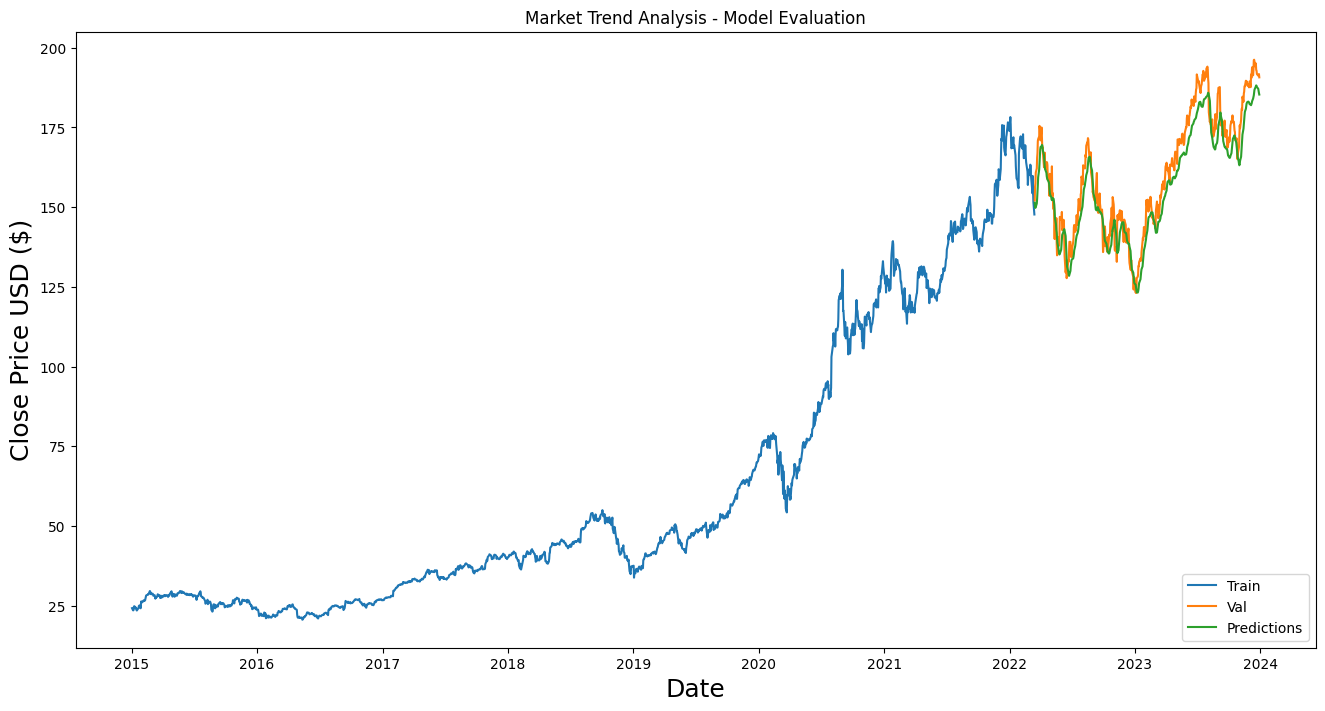

Ticker            AAPL  Predictions
Date                               
2023-12-15  195.721634   186.850830
2023-12-18  194.057327   187.603424
2023-12-19  195.097519   187.952484
2023-12-20  193.007263   188.200546
2023-12-21  192.858643   188.048065
2023-12-22  191.788757   187.701538
2023-12-26  191.243927   187.137436
2023-12-27  191.342957   186.460037
2023-12-28  191.768936   185.821274
2023-12-29  190.728760   185.336288


In [ ]:
# 5.4 Visualization (Analysis)
train = data[:training_data_len]
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Market Trend Analysis - Model Evaluation')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['AAPL'])
plt.plot(valid[['AAPL', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Show the actual vs predicted values
print(valid.tail(10))

**c. Performance Analysis**


The plot above visualizes the model's ability to track the market trend. While it may not predict the exact dollar amount every day perfectly (due to market noise), the trend lines (direction) of the predictions closely align with the actual values, validating the LSTM's utility for trend analysis.

**6. Ethical Considerations & Responsible AI**

**a. Bias and Fairness**

★Historical Bias: The model is trained on past 10 years of data. If the market structure changes fundamentally (e.g., a new pandemic or economic crash not seen in training data), the model may fail. It is biased towards "normal" market conditions.

★Data Quality: Public APIs may occasionally have missing or corrected data, which can skew predictions.

**b. Responsible Use**

Not Financial Advice: This AI tool is for educational and analytical purposes only. It should not be the sole basis for real-money trading.
Risk Warning: Financial forecasting is probabilistic. Users must be warned that AI cannot guarantee profits.

**7. Conclusion & Future Scope**

**a. Summary**

We successfully built an LSTM-based system that loads financial data, preprocesses it into sequences, and predicts future trends with a reasonable error margin (RMSE). The visualization confirms the model captures the general direction of the market.

**b. Improvements**

Hybrid Models: Incorporate Sentiment Analysis from news headlines (NLP) to handle "event-driven" price changes.
More Features: Add technical indicators like RSI or MACD to the input data.
Hyperparameter Tuning: Use GridSearch to find the optimal number of layers and epochs.